Goal: Detection of authentic news articles using ML and Auto-encoders  || Author: Israel Ilori || Date: October 2022

Our method of approach here is to first do some exploration on the dataset; to give us an idea of words which are contained in the corpus.
After which, we clean the text using a custom-built preprocessing function.
Next we use TF-IDF vectorizer to transform our text into vector matrices then 
Create a baseline algrithm using traditional ML. The ML of choice is a foundational LogisticRegression (LR) algorithm which is can be used for Binary Classification.

Summary:
    Using LR, the model seemed to perform well on the positive class but very poorly on the test set despite the dataset being fairly balanced.
    To improve the model:
        1. Extend the stopwords list, as the wordcloud showed commonly occuring words overlapping in both labels.
        3. Source for more training data for both classes, but with more focus on the negative class.
        2. To serve as a check, I would use an auto-encoder i.e HuggingFace's BERT to attempt to improve model performance. 

In [51]:
# import necessary packages
import nltk
import string
import numpy as np
import pandas as pd
nltk.download('stopwords')
nltk.download('punkt')
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oluwatomiwa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oluwatomiwa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# function to read in data into pandas

def read_data(text):

    data = pd.read_csv(text)
    
    data = data.drop_duplicates(subset=['text'])

    data = data.dropna(subset='text')

    return data


In [6]:
# read in data to pandas
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
label_data = pd.read_csv('labels.csv')

In [7]:
# starting with the train data, we explore the dataset further by viewing the top 5 rows
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
# check the shape of the data
train_data.shape

(20800, 5)

In [9]:
# drop duplicates values
train_data = train_data.drop_duplicates(subset=['text'])
train_data.shape                                                # re-check the shape

(20387, 5)

In [10]:
# check for null values
train_data.isnull().sum()

id           0
title      518
author    1854
text         1
label        0
dtype: int64

In [11]:
# we are mostly concerned with the text coloumn as we plan to limit this solution to just it 
# hence, for this reason we drop the 1 empty row on the text column
train_data = train_data.dropna(subset='text')

Repeat the process for the test dataset


In [12]:
# view the top 5 rows
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [13]:
# check the shape of the data
test_data.shape

(5200, 4)

In [14]:
# drop duplicates values
test_data = test_data.drop_duplicates(subset=['text'])
test_data.shape                                                # re-check the shape

(5127, 4)

In [15]:
# check for null values
test_data.isnull().sum()

id          0
title     120
author    490
text        1
dtype: int64

In [16]:
# drop empty rows for the text column
test_data = test_data.dropna(subset='text')

In [17]:
label_data.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


In [18]:
label_data.shape

(5200, 2)

From observation, we notice that the test dataset is unlabeled. 
However, in our label.csv data, we see corresponding IDs to that of the test set, which have labellings
Therefore, we merge the the label.csv to test.csv on the id column

In [19]:
# left join labels.csv to test.csv on ID column
new_test_data = pd.merge(test_data, label_data, how="left", on=["id"])

# then check the shape
new_test_data.shape

(5126, 5)

In [20]:
# now we have our new test dataset with our labels embedded within

new_test_data.head()

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


Check the data distribution of the training set

In [21]:
train_data['label'].value_counts()

0    10387
1     9999
Name: label, dtype: int64

The data looks fairly balanced

In [23]:
# cleaning function to remove 
#  stopwords,
#  punctuations, 
#  numrical values,
# ensure the text are english alphabets

remove_punctuation = str.maketrans('', '', string.punctuation)
stop_words = set(nltk.corpus.stopwords.words('english'))

def clean_text(text):
    uncased = text.translate(remove_punctuation).lower()
    tokens = [token for token in nltk.word_tokenize(uncased) 
                if len(token) > 1
                and not token in stop_words
                and not (token.isnumeric() and len(token) != 4)
                and (not token.isnumeric() or token.isalpha())]
    
    return " ".join(tokens)

In [24]:
# create a new column for the cleaned text in the training data

train_data['cleaned_text'] = train_data['text'].progress_apply(clean_text)
train_data.head()

100%|██████████| 20386/20386 [00:43<00:00, 464.23it/s]


,id,title,author,text,label,cleaned_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide even see comey letter jason cha...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october tension intellig...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,videos civilians killed single us airstrike id...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


In [28]:
# repeat process for the test data

new_test_data['cleaned_text'] = new_test_data['text'].progress_apply(clean_text)
new_test_data.head()

100%|██████████| 5126/5126 [00:11<00:00, 455.24it/s]


,id,title,author,text,label,cleaned_text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0,palo alto calif years scorning political proce...
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1,russian warships ready strike terrorists near ...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0,videos nodapl native american leaders vow stay...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1,first succeed try different sport tim tebow he...
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1,mins ago views comments likes first time histo...


Perform Word Cloud to get a glimpse of the data.

We want to build a word cloud for both class labels in question. And to kick this off, we start building the label for positive class

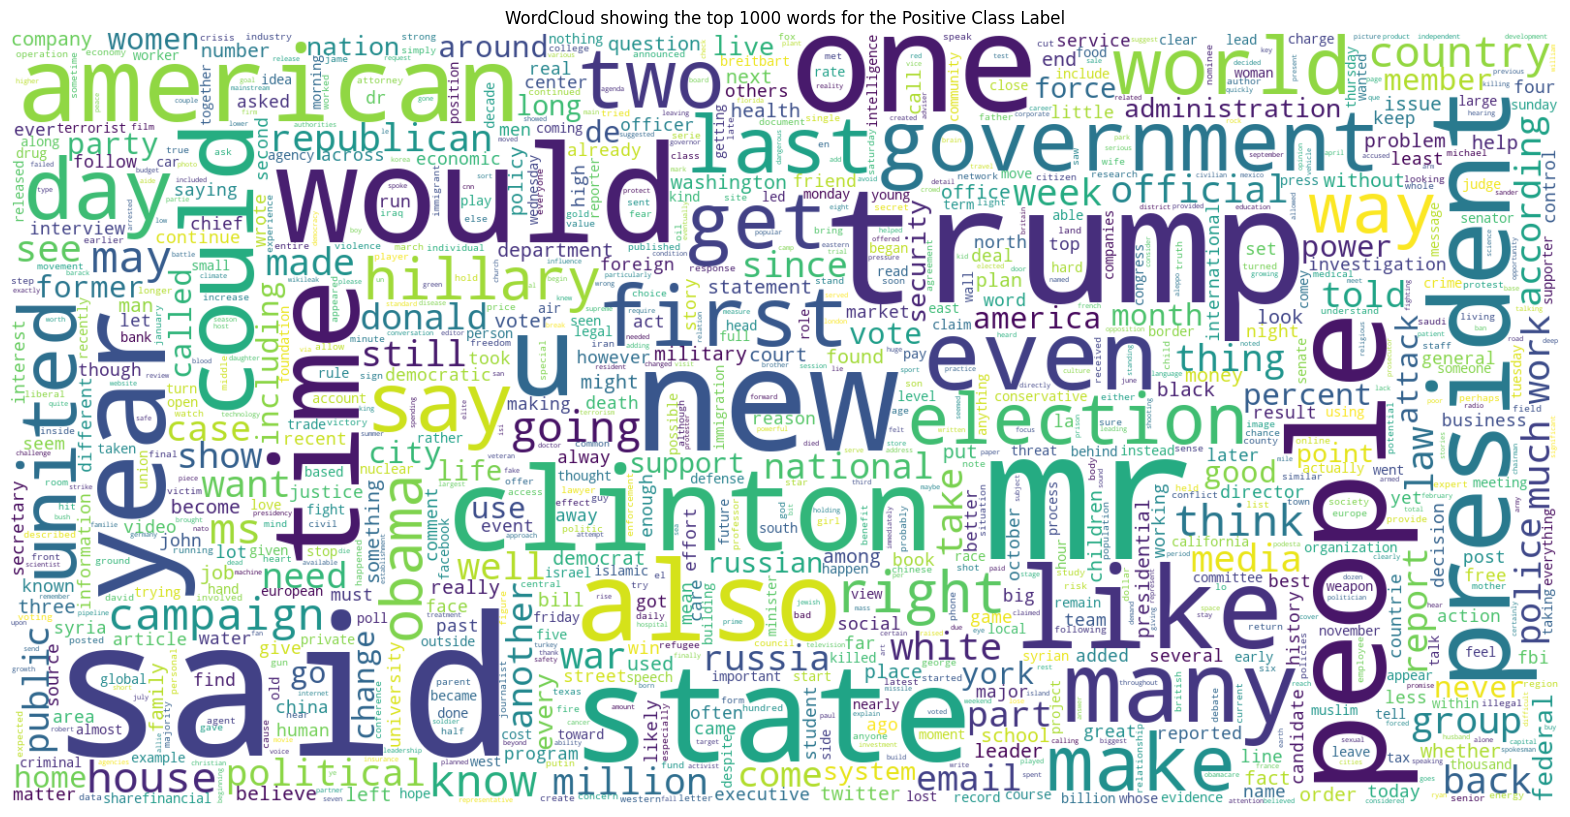

In [52]:
# get the class label for the positive class
train_data_positive = train_data[train_data['label'] == 1]

# convert to series
train_data_positive_strings = pd.Series(train_data['cleaned_text']).str.cat(sep=' ')


# plot wordcloud
train_data_positive_wordcloud = WordCloud(  width=1600, stopwords=stop_words, height=800,
                        max_font_size=200, max_words=1000, collocations=False,
                        background_color='white').generate(train_data_positive_strings)

plt.figure(figsize=(20,20))
plt.imshow(train_data_positive_wordcloud, interpolation="bilinear")
plt.title('WordCloud showing the top 1000 words for the Positive Class Label')
plt.axis("off")
plt.show()

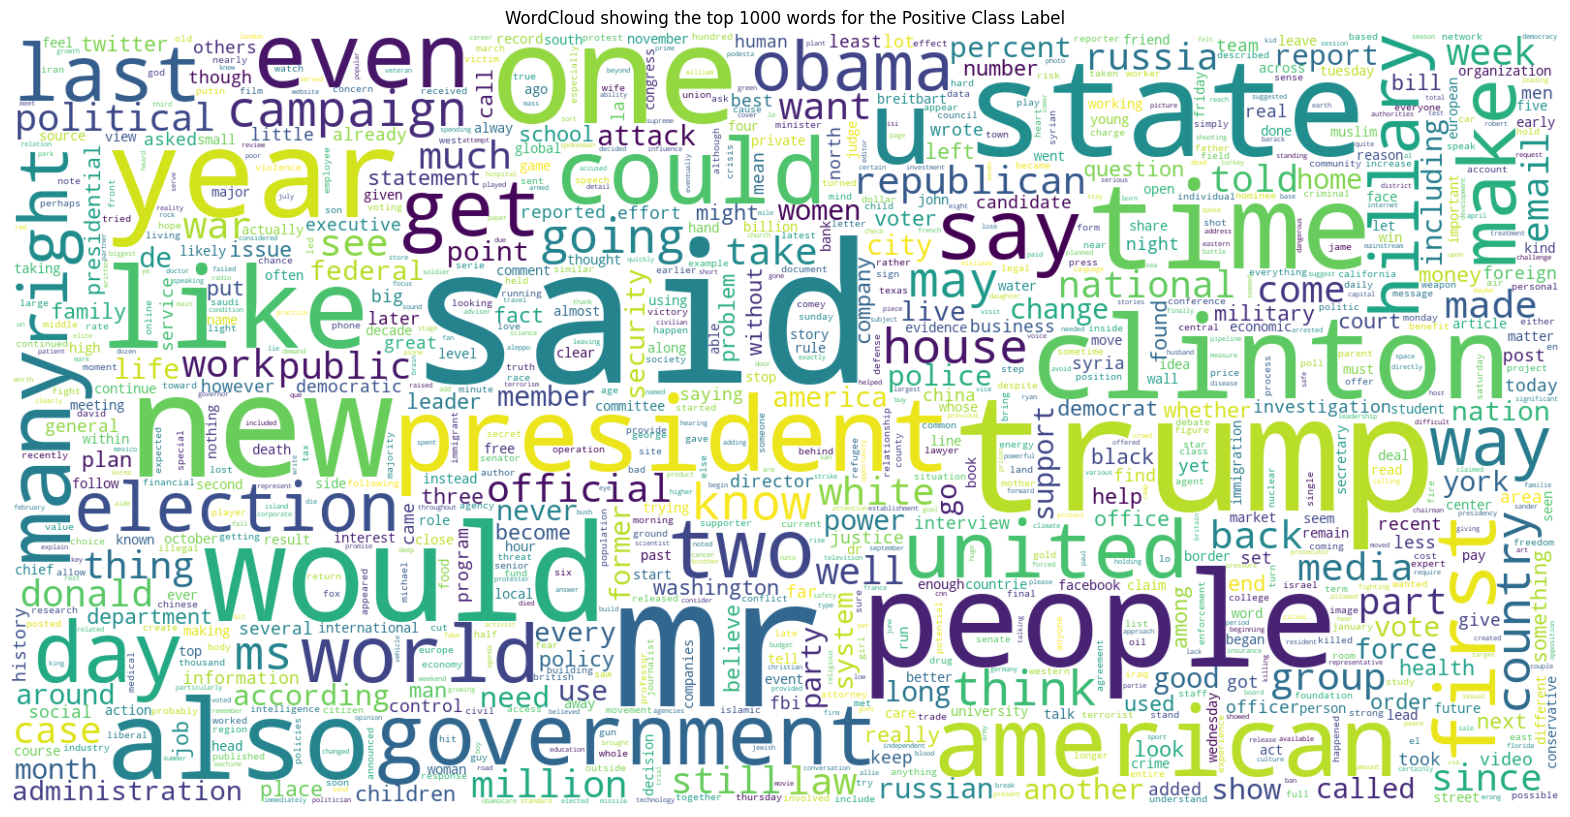

In [53]:
# get the class label for the negative class
train_data_negative = train_data[train_data['label'] == 0]

# convert to series
train_data_negative_strings = pd.Series(train_data['cleaned_text']).str.cat(sep=' ')


# plot wordcloud
train_data_negative_wordcloud = WordCloud(  width=1600, stopwords=stop_words, height=800,
                        max_font_size=200, max_words=1000, collocations=False,
                        background_color='white').generate(train_data_negative_strings)

plt.figure(figsize=(20,20))
plt.imshow(train_data_negative_wordcloud, interpolation="bilinear")
plt.title('WordCloud showing the top 1000 words for the Negative Class Label')
plt.axis("off")
plt.show()

Build the ML Algorithm

In [46]:
# performing the multiclass classification

X_train = train_data['cleaned_text']
y_train = train_data['label']

X_test = new_test_data['cleaned_text']
y_test = new_test_data['label']


# instantiate the vectorizer
tfidf_vect = TfidfVectorizer(max_features=5000)

X_train_vectorized = tfidf_vect.fit_transform(X_train)
X_test_vectorized = tfidf_vect.fit_transform(X_test)


# instantiate the LR Classifier with an ovr multi_class attribute: because the problem is a binary one
model_linear = LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear').fit(X_train_vectorized, y_train)

In [47]:
# make predictions on the validation set
y_pred = model_linear.predict(X_test_vectorized)
accuracy = accuracy_score(y_pred, y_test)

skf7 = StratifiedKFold(n_splits=7)

scores = cross_val_score(model_linear, X_train_vectorized, y_train, scoring='accuracy', cv=skf7, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.946 (0.007)


In [49]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.19      0.27      2330
           1       0.56      0.85      0.67      2796

    accuracy                           0.55      5126
   macro avg       0.53      0.52      0.47      5126
weighted avg       0.53      0.55      0.49      5126

